<a href="https://colab.research.google.com/github/ov29/Research_project/blob/main/train_target_adult.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.   The code creates and trains a model on the Adult dataset.
2.   It evaluates the model's performance on training and testing data.


3.   It prepares datasets for a membership inference attack, where the goal is to determine if specific instances were part of the training set.
4.   Also trains a neural network on a dataset and then investigates how well the model can be reverse-engineered to identify if specific data points were used during training.












usage: colab_kernel_launcher.py [-h] [--layers LAYERS] [--optimizer OPTIMIZER]
                                [--l1_rate L1_RATE] [--l2_rate L2_RATE]
                                [--dropout DROPOUT] [--epochs EPOCHS]
                                [--batch_size BATCH_SIZE]
colab_kernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-6e7e90fb-2469-4f8c-8601-bc1fba3975cb.json


Hyperparameters:  {'layers': 1, 'optimizer': 'adam', 'l1_rate': 0, 'l2_rate': 0, 'dropout': 0, 'epochs': 25, 'batch_size': 16}
Epoch 1/25
2262/2262 [==============================] - 7s 3ms/step - loss: 0.3567 - accuracy: 0.8348 - precision: 0.8348 - recall: 0.8348 - val_loss: 0.3281 - val_accuracy: 0.8426 - val_precision: 0.8426 - val_recall: 0.8426
Epoch 2/25
2262/2262 [==============================] - 7s 3ms/step - loss: 0.3226 - accuracy: 0.8488 - precision: 0.8488 - recall: 0.8488 - val_loss: 0.3196 - val_accuracy: 0.8493 - val_precision: 0.8493 - val_recall: 0.8493
Epoch 3/25
2262/2262 [==============================] - 6s 3ms/step - loss: 0.3195 - accuracy: 0.8508 - precision: 0.8508 - recall: 0.8508 - val_loss: 0.3180 - val_accuracy: 0.8496 - val_precision: 0.8496 - val_recall: 0.8496
Epoch 4/25
2262/2262 [==============================] - 7s 3ms/step - loss: 0.3169 - accuracy: 0.8518 - precision: 0.8518 - recall: 0.8518 - val_loss: 0.3169 - val_accuracy: 0.8511 - val_precisio

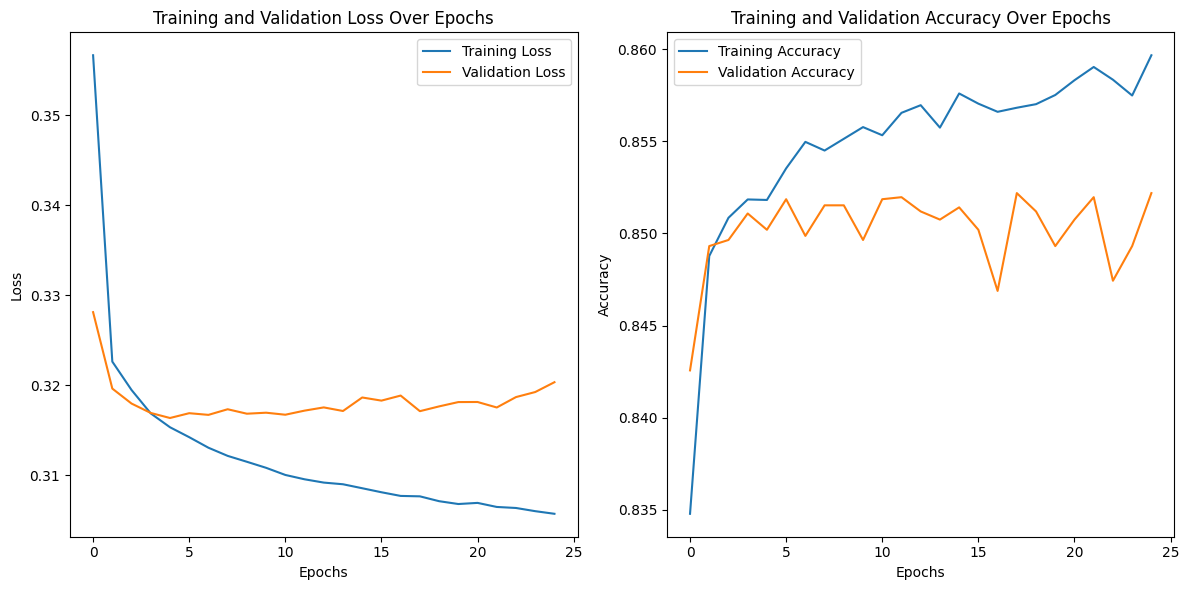

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                1040      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 output_layer (Dense)        (None, 2)                 22        
                                                                 
Total params: 1062 (4.15 KB)
Trainable params: 1062 (4.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train-Accuracy: 0.8596622347831726
Test-Accuracy: 0.8521835207939148
1131/1131 [==============================] - 2s 2ms/step
Creating train/test csv files... [COMPLETED]

Shuffling train/test csv files... [COMPLETED]

The train/test subsets to train the membership inference attack model

In [1]:
"""
This script trains an MLP on the Adult dataset. The parameters of the model, such as its depth, regularization, dropout, etc.,
can be provided by the user. Finally, the predictions of the trained model on each train/test instance are acquired and
a new dataset, where half of the records are members in the training set and half of them are not, is created. Each
record in the new dataset contains the output predictions of the trained model and a label corresponding to whether the
instance that triggered those outputs was a member (0) or not (1) in the original train or test datasets, respectively.
"""
!pip install matplotlib

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn import preprocessing
import random
import argparse
from keras import models
from keras import layers
from keras import regularizers
from sklearn.model_selection import train_test_split
import os
import json

# Function to create a directory for experiment results
def directory_creator():
    """
    Creates a directory named exp and an integer indicating the no. of experiment.
    This directory will host the train/test subsets to be used for conducting membership inference attacks.
    :return: the path of the results hosting directory
    """
    path = "adult/"
    if not os.path.exists("adult"):
        os.makedirs(path)
        path = path+"exp0"
        os.makedirs(path)
    else:
        dirs = os.listdir(path)
        count_max = 0
        for dir in dirs:
            if not os.path.isdir(path + dir) or 'exp' not in dir:
                continue
            exp_no = dir.replace('exp', '')
            try:
                exp_no = int(exp_no)
            except:
                # cannot convert to int
                continue
            if exp_no > count_max:
                count_max = exp_no
        path = "adult/exp" + str(count_max+1)
        os.makedirs(path)
    return path

# Main function
def main():
    # Create a directory for experiment results
    results_path = directory_creator()

    # Parse command-line arguments or use default values
    opt = parse_opt()
    with open(results_path + '/info.txt', 'w') as file:
        file.write(json.dumps(opt) + "\n")
    print("Hyperparameters: ", opt)

    # Load the data
    header = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
              'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'salary']
    try:
        df = pd.read_csv("adults.csv", index_col=False, skipinitialspace=True, header=None, names=header)
    except:
        df = pd.read_csv("https://raw.githubusercontent.com/aliakbarbadri/mlp-classifier-adult-dataset/master/adults.csv",
                         index_col=False, skipinitialspace=True, header=None, names=header)

    # Preprocess dataset
    # Drop nan values
    df = df.replace('?', np.nan)
    df.dropna(inplace=True)

    # Handle categorical columns
    df.drop('education-num', axis=1, inplace=True)
    categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex',
                            'native-country']
    label_column = ['salary']
    convert_to_int(label_column, df)
    df = convert_to_onehot(df, categorical_columns)

    # Normalize numerical columns
    normalize_columns = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']
    normalize(normalize_columns, df)

    x_data = df.drop('salary', axis=1)
    y_labels = df['salary']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_labels, test_size=0.2, shuffle=True)

    # Convert labels to one-hot encoding
    y_train = tf.one_hot(y_train, depth=2)
    y_test = tf.one_hot(y_test, depth=2)

    # Create and train the target model
    model = models.Sequential()
    model.add(layers.InputLayer(X_train.shape[1:], name='input_layer'))

    # Hidden layers
    for i in range(opt['layers']):
        model.add(layers.Dense(10, activation="relu",
                               kernel_regularizer=regularizers.l2(l=opt['l2_rate']) if opt['l1_rate'] == 0 else regularizers.l1(l=opt['l1_rate'])))
        model.add(layers.Dropout(opt['dropout'], noise_shape=None, seed=None))

    # Output layer
    model.add(layers.Dense(2, activation="softmax", name='output_layer'))

    optimizer = tf.keras.optimizers.AdamW() if opt['optimizer'] == 'adamw' else opt['optimizer']

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy", "Precision", "Recall"]
    )

   # Train the model
    results = model.fit(
        X_train, y_train,
        epochs=opt['epochs'],
        batch_size=opt['batch_size'],
        validation_data=(X_test, y_test)
    )

    # Plot training and validation accuracy over epochs
    plt.figure(figsize=(12, 6))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(results.history['loss'], label='Training Loss')
    plt.plot(results.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(results.history['accuracy'], label='Training Accuracy')
    plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
    # Print model summary and evaluation metrics
    model.summary()
    print("Train-Accuracy:", np.mean(results.history["accuracy"][-1]))
    print("Test-Accuracy:", np.mean(results.history["val_accuracy"][-1]))

    # Save training accuracy and test accuracy in info.txt
    with open(results_path + '/info.txt', 'a') as file:
        file.write("Train-Accuracy:" + str(np.mean(results.history["accuracy"][-1])) + "\n")
        file.write("Test-Accuracy:" + str(np.mean(results.history["val_accuracy"][-1])))

    # Get predictions on member and non-member records and create the membership inference dataset
    pred = model.predict(X_test)
    np.random.shuffle(pred)
    pred_train = model.predict(X_train)
    pred_train = pred_train[:len(pred)]  # select the same no. of instances with the cardinality of the test set
    np.random.shuffle(pred_train)

    # Create train/test CSV files
    print("Creating train/test csv files...", end="")
    create_train_test_subsets(pred_train, pred, results_path)
    print(" [COMPLETED]")
    print()
    print("Shuffling train/test csv files...", end="")
    shuffle_data(results_path)
    print(" [COMPLETED]")
    print()
    print("The train/test subsets to train the membership inference attack model are located in: " + results_path)
    print()
    exit(0)

# Helper function to convert specified columns to integers
def convert_to_int(columns, df):
    for column in columns:
        unique_values = df[column].unique().tolist()
        dic = {}
        for indx, val in enumerate(unique_values):
            dic[val] = indx
        df[column] = df[column].map(dic).astype(int)

# Helper function to convert specified columns to one-hot encoding
def convert_to_onehot(data, columns):
    dummies = pd.get_dummies(data[columns])
    data = data.drop(columns, axis=1)
    data = pd.concat([data, dummies], axis=1)
    return data

# Helper function to normalize specified columns
def normalize(columns, df):
    scaler = preprocessing.StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])

# Helper function to shuffle data in CSV files
def shuffle_data(results_path):
    with open(results_path+"/train.csv", 'r') as file:
        lines = file.readlines()
    random.shuffle(lines)
    with open(results_path+"/train.csv", 'w') as file:
        for line in lines:
            file.write(line)

    with open(results_path+"/test.csv", 'r') as file:
        lines = file.readlines()
    random.shuffle(lines)
    with open(results_path+"/test.csv", 'w') as file:
        for line in lines:
            file.write(line)

# Helper function to create train/test subsets for membership inference
def create_train_test_subsets(pred_train, pred, results_path):
    with open(results_path+'/train.csv', 'w') as file:
        for line in pred_train[:500]:
            for i in line:
                file.write(str(i) + ",")
            file.write('0\n')
        for line in pred[:500]:
            for i in line:
                file.write(str(i) + ",")
            file.write('1\n')

    with open(results_path+'/test.csv', 'w') as file:
        for line in pred_train[500:]:
            for i in line:
                file.write(str(i) + ",")
            file.write('0\n')
        for line in pred[500:]:
            for i in line:
                file.write(str(i) + ",")
            file.write('1\n')

# Parse command-line arguments or use default values
def parse_opt():
    parser = argparse.ArgumentParser()
    parser.add_argument('--layers', type=int, default=1, help='number of hidden layers for the MLP architecture')
    parser.add_argument('--optimizer', type=str, default='adam',
                        help='optimizer options: sgd, adam, rmsprop, adamax, adadelta, adagrad, adamw')
    parser.add_argument('--l1_rate', type=float, default=0, help='l1 regularisation rate per layer')
    parser.add_argument('--l2_rate', type=float, default=0, help='l2 regularisation rate per layer')
    parser.add_argument('--dropout', type=float, default=0, help='dropout rate per layer')
    parser.add_argument('--epochs', type=int, default=25, help='no. of training epochs')
    parser.add_argument('--batch_size', type=int, default=16, help='batch size')

    try:
        # Attempt to parse command-line arguments
        opt = parser.parse_args()
    except:
        # Use default values if parsing fails (e.g., when running in a Jupyter notebook)
        opt = {
            'layers': 1,
            'optimizer': 'adam',
            'l1_rate': 0,
            'l2_rate': 0,
            'dropout': 0,
            'epochs': 25,
            'batch_size': 16
        }

    return opt

# Execute the program
main()


